## Import Dependencies

In [15]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default plot style
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_style("darkgrid")

# Set the seed for reproducibility
seed = 12
np.random.seed(seed)

In [16]:
img_id = 3
save_imgs = False

## Generate Data

In [17]:
d = 100  # Number of features
m = 50  # Output dimension
n = 1000  # Number of samples
rank = 10  # Rank of the matrix W

# Eigen gaps
# S_delta = [10] * 8 + [9]  
S_delta = [1.1] * 9
# S_delta = [1.1, 1.1, 1.1, -50, 50, 1.1, 1.1, 1.1, 1.1]
print("Eigen gaps:", S_delta)

Eigen gaps: [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]


In [18]:
X = np.random.randn(d, n)  # Generating the input data
X = X / la.norm(X, axis=0, keepdims=True)  # Normalizing the data

M = np.random.randn(m, d)  # Generating a random matrix M
U, _, Vt = la.svd(M, full_matrices=False)  # Performing the SVD of M

S = [1] * rank
for i in range(rank - 2, -1, -1):
    S[i] = S[i + 1] + S_delta[i]

print("Eigen values:", S)

B_star = U[:, :rank] @ np.sqrt(np.diag(S))  # Generating the matrix B_star
A_star = np.sqrt(np.diag(S)) @ Vt[:rank, :]  # Generating the matrix A_star

W_star = B_star @ A_star  # Generating the matrix W_star

Y_star = W_star @ X  # Generating the output data Y_star

# Y = Y_star  # No noise added
Y = Y_star + 0.1 * np.random.randn(m, n) # Adding noise to the output data

print("B_star shape: ", B_star.shape, "(m, rank)")
print("A_star shape: ", A_star.shape, "(rank, d)")
print("W_star shape: ", W_star.shape, "(m, d)")
print("X shape: ", X.shape, "(d, n)")
print("Y shape: ", Y.shape, "(m, n)")

Eigen values: [10.899999999999999, 9.799999999999999, 8.7, 7.6, 6.5, 5.4, 4.300000000000001, 3.2, 2.1, 1]
B_star shape:  (50, 10) (m, rank)
A_star shape:  (10, 100) (rank, d)
W_star shape:  (50, 100) (m, d)
X shape:  (100, 1000) (d, n)
Y shape:  (50, 1000) (m, n)


In [19]:
class Rank1_LinearRegression:
    def __init__(self, m, d) -> None:
        self.B = np.random.randn(m, 1)
        self.A = np.random.randn(1, d)
        self.training_loss = []

    def loss(self, X, Y, grad=False):
        if grad:
            grad_A = self.B.T @ (self.B @ self.A @ X - Y) @ X.T / X.shape[1]
            grad_B = (self.B @ self.A @ X - Y) @ X.T @ self.A.T / X.shape[1]
            return grad_A, grad_B
        else:
            return 0.5 * la.norm(Y - self.B @ self.A @ X, ord="fro") ** 2 / X.shape[1]

    def fit(self, X, Y, lr=(0.1, 0.1), epochs=500):
        self.training_loss = []
        for _ in range(epochs):
            grad_A, grad_B = self.loss(X, Y, grad=True)
            self.A -= lr[0] * grad_A
            self.B -= lr[1] * grad_B
            self.training_loss.append(self.loss(X, Y))
        return self.training_loss

    def plot_loss(self, title="Rank-1 Linear Regression"):
        plt.figure(figsize=(5, 2))
        sns.lineplot(
            x=range(len(self.training_loss)),
            y=self.training_loss,
            label=f"Final Loss: {self.training_loss[-1]:.4f}",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title(title)
        plt.show()

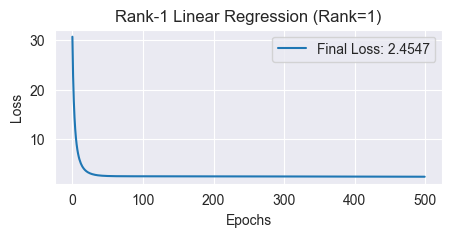

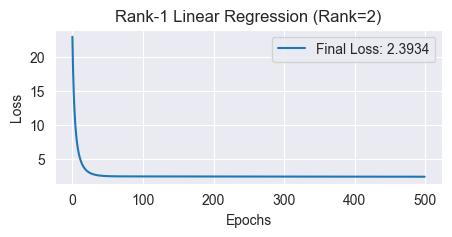

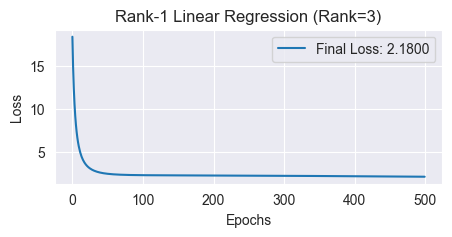

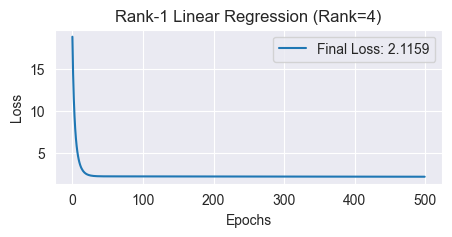

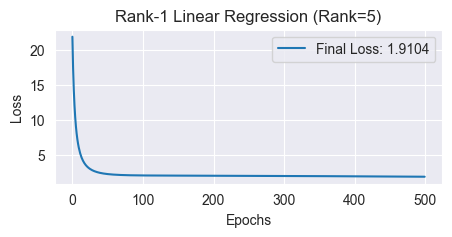

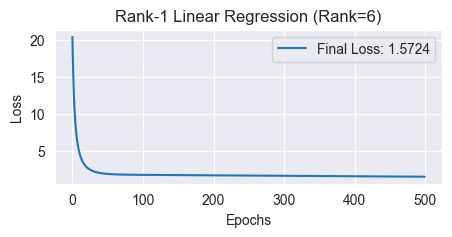

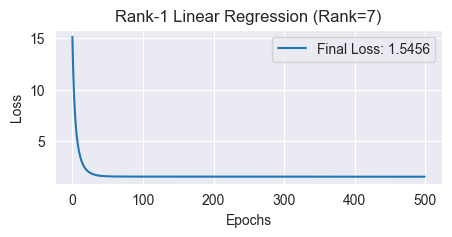

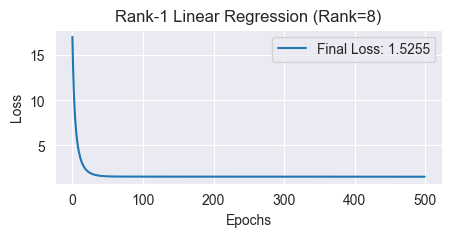

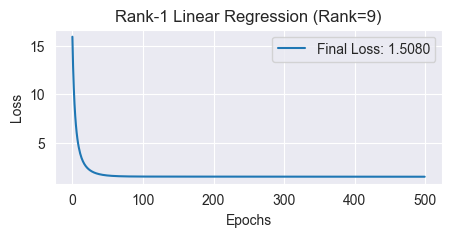

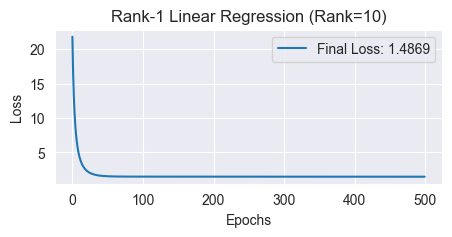

In [20]:
Y_k = Y
r1_lrs = []
A_r1s = None
B_r1s = None

for r in range(1, rank + 1):
    # Rank-1 Linear Regression Training
    r1_lr = Rank1_LinearRegression(m, d)
    r1_lr.fit(X, Y_k, lr=(0.1, 0.1), epochs=500)

    # Plotting the loss
    r1_lr.plot_loss(title=f"Rank-1 Linear Regression (Rank={r})")

    # Deflation
    Y_k = Y_k - r1_lr.B @ r1_lr.A @ X

    # Saving the model
    A_r1s = r1_lr.A if A_r1s is None else np.vstack((A_r1s, r1_lr.A))
    B_r1s = r1_lr.B if B_r1s is None else np.hstack((B_r1s, r1_lr.B))
    r1_lrs.append(r1_lr)

In [21]:
class Rank1_LinearRegression_Orth(Rank1_LinearRegression):
    def __init__(self, m, d) -> None:
        super().__init__(m, d)

    def gram_schmidt_orth(self, A_prev, B_prev, A_r, B_r):
        # B_prev: (m x r-1) | A_prev: (r-1 x d)
        # B_r: (m x 1) | A_r: (1 x d)

        # Orthogonalize A_r with respect to the columns in A_prev
        for i in range(A_prev.shape[0]):
            projection = np.dot(A_r, A_prev[i].T) / np.dot(A_prev[i], A_prev[i].T)
            A_r -= projection * A_prev[i]

        # Orthogonalize B_r with respect to the rows in B_prev
        for i in range(B_prev.shape[1]):
            projection = np.dot(B_prev[:, i].T, B_r) / np.dot(
                B_prev[:, i], B_prev[:, i].T
            )
            B_r -= projection * B_prev[:, i : i + 1]

        return A_r, B_r
    

    def fit(self, X, Y, A_prev, B_prev, lr=(0.1, 0.1), epochs=500):
        self.training_loss = []
        for _ in range(epochs):
            # Compute the gradients
            grad_A, grad_B = self.loss(X, Y, grad=True)

            # Update the weights
            self.A -= lr[0] * grad_A
            self.B -= lr[1] * grad_B

            # Orthogonalize the current A and B with respect to the previous A and B
            if A_prev is not None:
                self.A, self.B = self.gram_schmidt_orth(A_prev, B_prev, self.A, self.B)

            # Compute the loss
            self.training_loss.append(self.loss(X, Y))
        return self.training_loss

    def plot_loss(self, title="Rank-1 Linear Regression Orthogonalized"):
        super().plot_loss(title)

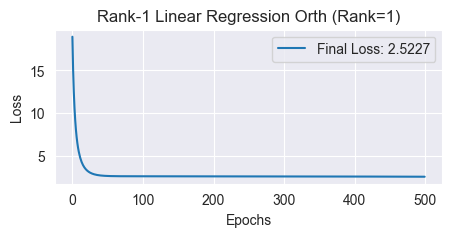

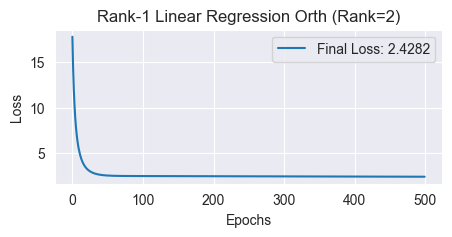

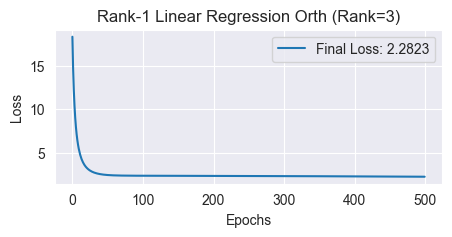

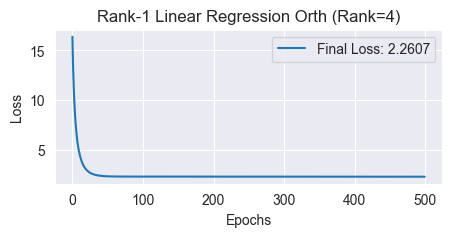

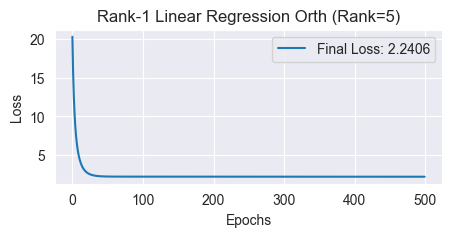

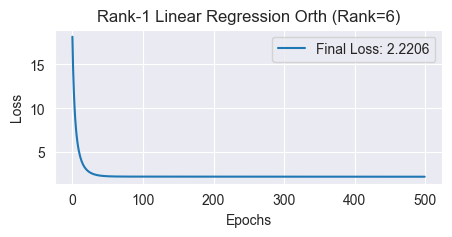

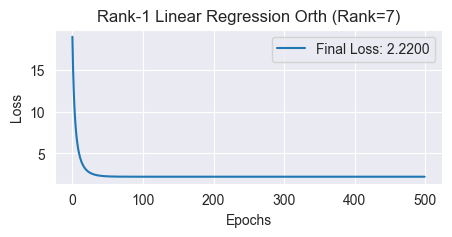

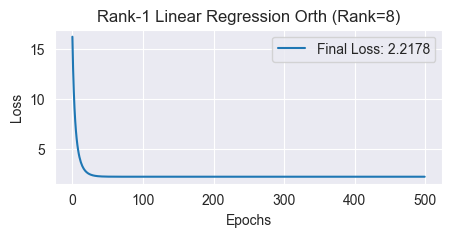

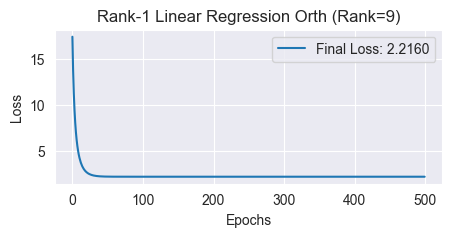

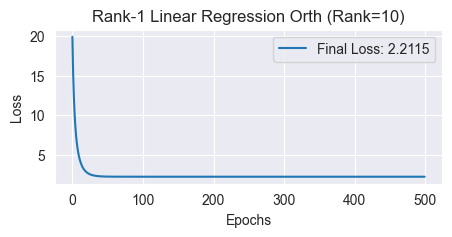

In [22]:

Y_k = Y
r1_lrs_orth = []
A_r1s_orth = None
B_r1s_orth = None

for r in range(1, rank + 1):
    # Rank-1 Linear Regression Training
    r1_lr = Rank1_LinearRegression_Orth(m, d)
    r1_lr.fit(X, Y_k, A_r1s_orth, B_r1s_orth, lr=(0.1, 0.1), epochs=500)

    # Plotting the loss
    r1_lr.plot_loss(title=f"Rank-1 Linear Regression Orth (Rank={r})")

    # Deflation
    Y_k = Y_k - r1_lr.B @ r1_lr.A @ X

    # Saving the model
    A_r1s_orth = r1_lr.A if A_r1s_orth is None else np.vstack([A_r1s_orth, r1_lr.A])
    B_r1s_orth = r1_lr.B if B_r1s_orth is None else np.hstack([B_r1s_orth, r1_lr.B])
    r1_lrs_orth.append(r1_lr)

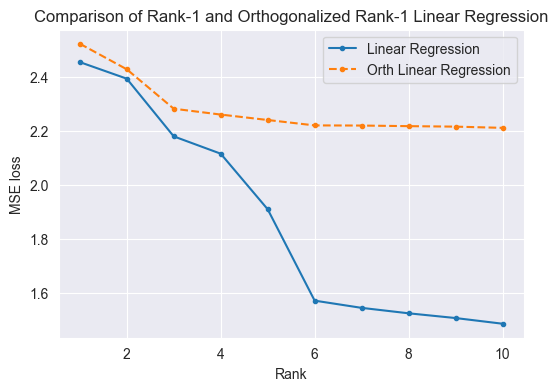

In [23]:

plt.plot(
    range(1, rank + 1),
    [r1_lrs[r].training_loss[-1] for r in range(rank)],
    label=f"Linear Regression",
    marker=".",
)
plt.plot(
    range(1, rank + 1),
    [r1_lrs_orth[r].training_loss[-1] for r in range(rank)],
    label=f"Orth Linear Regression",
    marker=".",
    linestyle="--",
)
plt.xlabel("Rank")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Comparison of Rank-1 and Orthogonalized Rank-1 Linear Regression")

if save_imgs:
    plt.savefig(f"images/img{img_id}_1.png")

plt.show()

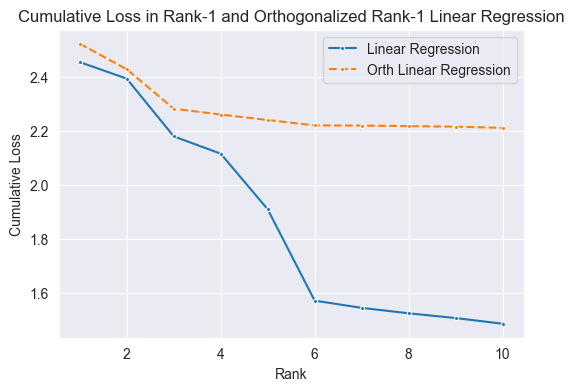

In [24]:
# Comparing cumulative loss A and B matrices in increasing rank
W, W_orth = np.zeros((m, d)), np.zeros((m, d))
cum_loss, cum_loss_orth = [], []
relative_errors, relative_errors_orth = [], []

for r in range(rank):
    # Accumulating the ranks sequentially
    W += r1_lrs[r].B @ r1_lrs[r].A
    W_orth += r1_lrs_orth[r].B @ r1_lrs_orth[r].A
    
    # Computing the loss
    Y_pred = W @ X
    Y_pred_orth = W_orth @ X

    # Storing Relative Errors
    relative_errors.append(la.norm(W - W_star, ord="fro") / la.norm(W_star, ord="fro"))
    relative_errors_orth.append(la.norm(W_orth - W_star, ord="fro") / la.norm(W_star, ord="fro"))

    # Accumulating the loss
    cum_loss.append(la.norm(Y - Y_pred, ord="fro") ** 2 / (2 * n))
    cum_loss_orth.append(la.norm(Y - Y_pred_orth, ord="fro") ** 2 / (2 * n))
    
sns.lineplot(x=range(1, rank + 1), y=cum_loss, label="Linear Regression", marker=".")
sns.lineplot(x=range(1, rank + 1), y=cum_loss_orth, label="Orth Linear Regression", marker=".", linestyle="--")
plt.xlabel("Rank")
plt.ylabel("Cumulative Loss")
plt.legend()
plt.title("Cumulative Loss in Rank-1 and Orthogonalized Rank-1 Linear Regression")

if save_imgs:
    plt.savefig(f"images/img{img_id}_2.png")

plt.show()

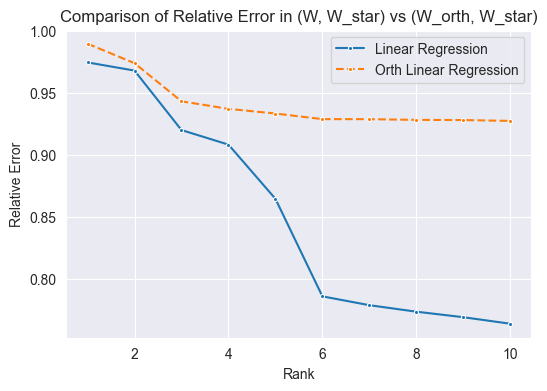

In [25]:
# Plotting the relative errors
sns.lineplot(x=range(1, rank + 1), y=relative_errors, label="Linear Regression", marker=".")
sns.lineplot(x=range(1, rank + 1), y=relative_errors_orth, label="Orth Linear Regression", marker=".", linestyle="--")
plt.xlabel("Rank")
plt.ylabel("Relative Error")
plt.legend()
plt.title("Comparison of Relative Error in (W, W_star) vs (W_orth, W_star)")

if save_imgs:
    plt.savefig(f"images/img{img_id}_3.png")

plt.show()

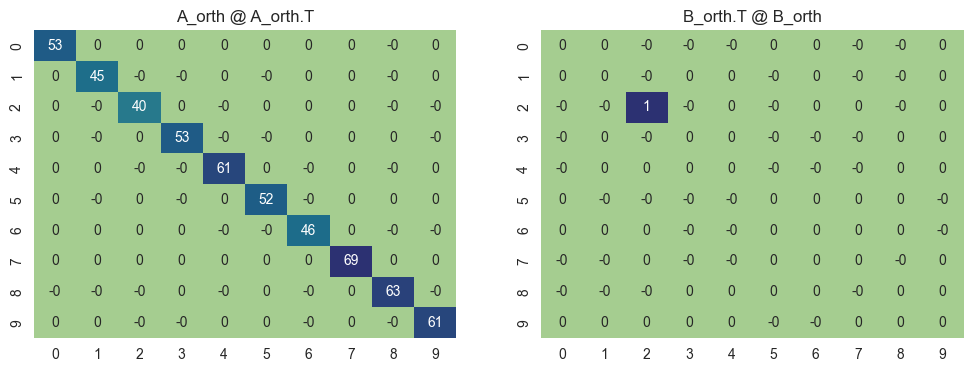

In [27]:
# Verifying orthogonality of the A_orth and B_orth matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(
    np.round(A_r1s_orth @ A_r1s_orth.T), annot=True, fmt="g", cmap="crest", cbar=False
)
plt.title("A_orth @ A_orth.T")

plt.subplot(1, 2, 2)
sns.heatmap(
    np.round(B_r1s_orth.T @ B_r1s_orth), annot=True, fmt="g", cmap="crest", cbar=False
)
plt.title("B_orth.T @ B_orth")

if save_imgs:
    plt.savefig(f"images/img{img_id}_4.png")

plt.show()

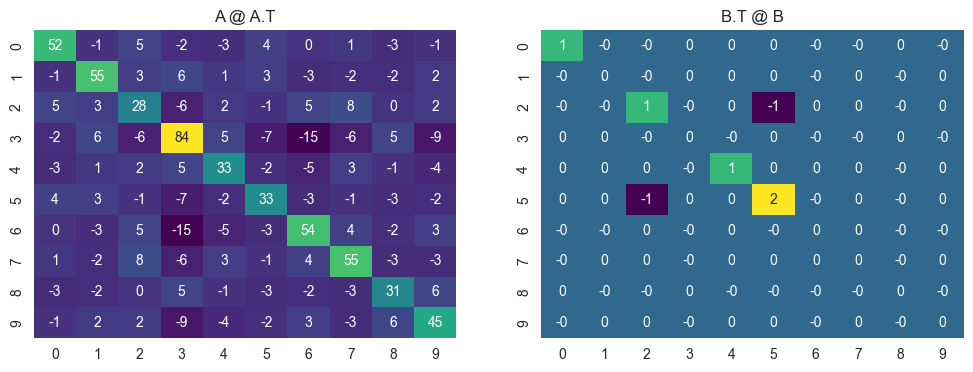

In [28]:
# Verifying orthogonality of the A and B matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(
    np.round(A_r1s @ A_r1s.T), annot=True, fmt="g", cmap="viridis", cbar=False
)
plt.title("A @ A.T")

plt.subplot(1, 2, 2)
sns.heatmap(
    np.round(B_r1s.T @ B_r1s), annot=True, fmt="g", cmap="viridis", cbar=False
)
plt.title("B.T @ B")

if save_imgs:
    plt.savefig(f"images/img{img_id}_5.png")

plt.show()